# Predicción de la tasa de anillamiento de aves
**Autores:** DANIELLE MAREE MCKENNEY & MARIA JOSÉ CASTRO PÉREZ   &nbsp;&nbsp;&nbsp; **Última modificación:** 14/01/2024

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Lectura del dataset

### 1.1 Definición de funciones auxiliares

In [4]:
def cleanRawData(rawData, relevantColumns):
    # returns a dataframe with only the relevent columns and with invalid location entries removed
    df = rawData.filter(items=relevantColumns)
    df = df[(df['decimalLatitude'] != 0) & (df['decimalLongitude'] != 0)]
    return df

def fillInCounts0(data, dateCombination):
    # Fill in count=0 in the grouped summary
    # Get all unique combinations of the date combination
    existing_combinations = data[dateCombination].drop_duplicates()

    # Create a DataFrame with all unique species
    all_species_combinations = pd.DataFrame({'species': data['species'].unique()})

    # Cross join (cartesian product) to get all combinations of 'species', 'eventDate', and 'locality'
    all_combinations = pd.merge(existing_combinations.assign(key=1), all_species_combinations.assign(key=1), on='key').drop('key', axis=1)

    # Merge with the original DataFrame to get counts
    on = dateCombination.append('species')
    result_df = pd.merge(all_combinations, data, on=on, how='left').fillna(0)
    return result_df

In [5]:
## 1. LECTURA DEL DATASET
DATOS = pd.read_csv('./DATASET.csv', sep="\t", on_bad_lines="warn")
relevantColumns = ['species','locality','decimalLatitude', 'decimalLongitude', 'eventDate', 'stateProvince']

df = cleanRawData(DATOS, relevantColumns)

In [6]:
df

,species,locality,decimalLatitude,decimalLongitude,eventDate,stateProvince
0,Turdus merula,Zona de huertos,41.80000,-2.78333,1980-09-11T00:00:00,Soria
1,Turdus merula,Sant esteve de la sarga,42.06667,0.76667,1983-09-30T00:00:00,Lleida
2,Turdus merula,Sagunto,39.66667,-0.28333,1980-07-12T00:00:00,Valencia
3,Turdus merula,Viernoles,43.31667,-6.06667,1981-03-08T00:00:00,Cantabria
4,Turdus merula,Finca cienfuegos,40.61667,-2.98333,1985-03-31T00:00:00,Guadalajara
...,...,...,...,...,...,...
753574,Phylloscopus collybita,Azuqueca de henares,40.55000,-3.25000,2013-12-27T00:00:00,Guadalajara
753575,Phylloscopus collybita,Reserva del tancat de la pipa,39.35806,-0.36333,2015-01-26T00:00:00,Valencia
753576,Phylloscopus collybita,Tancat de milia,39.31389,-0.36444,2018-12-01T00:00:00,Valencia
753577,Phylloscopus collybita,Navas del rey,40.38333,-4.26667,2019-02-23T00:00:00,Madrid


### 1.2 Agrupaciones por semana, mes, quarter y año

In [12]:

# Group by 'species', 'eventDate', and 'stateProvince' and count the rows in each group
grouped_eventDate_df = df.groupby(['species', 'eventDate', 'stateProvince']).size().reset_index(name='count')
# Fill in count=0 on days where a locality was visited but no entry was made for that species
grouped_eventDate_df = fillInCounts0(grouped_eventDate_df, ['eventDate', 'stateProvince'])
#print(grouped_eventDate_df[10:])


# Supongamos que 'grouped_eventDate_df' es tu DataFrame y 'eventDate' es la columna que contiene fechas
grouped_eventDate_df['eventDate'] = pd.to_datetime(grouped_eventDate_df['eventDate'])

grouped_eventDate_df['weekOfYear'] = grouped_eventDate_df['eventDate'].dt.isocalendar().week 
grouped_eventDate_df['month'] = grouped_eventDate_df['eventDate'].dt.month
grouped_eventDate_df['quarter'] = grouped_eventDate_df['eventDate'].dt.to_period('Q')
grouped_eventDate_df['year'] = grouped_eventDate_df['eventDate'].dt.year

grouped_weekOfYear_df = grouped_eventDate_df.groupby(['species', 'weekOfYear', 'year', 'stateProvince']).sum('count').reset_index()

grouped_month_df = grouped_eventDate_df.groupby(['species', 'month', 'year', 'stateProvince']).sum('count').reset_index()

grouped_quarter_df = grouped_eventDate_df.groupby(['species', 'quarter', 'stateProvince']).sum('count').reset_index()

grouped_year_df = grouped_eventDate_df.groupby(['species', 'year', 'stateProvince']).sum('count').reset_index()



In [19]:
grouped_month_df.head





<bound method NDFrame.head of                  species  month  year stateProvince  count  weekOfYear
0        Merops apiaster      1  1960         Cadiz    0.0           3
1        Merops apiaster      1  1960        Girona    0.0           2
2        Merops apiaster      1  1960     Guipuzcoa    0.0           2
3        Merops apiaster      1  1960      Valencia    0.0           2
4        Merops apiaster      1  1962       Almeria    0.0           6
...                  ...    ...   ...           ...    ...         ...
68847  Turdus philomelos     12  2018        Teruel    1.0         100
68848  Turdus philomelos     12  2018        Toledo    1.0         454
68849  Turdus philomelos     12  2018      Valencia   13.0        1205
68850  Turdus philomelos     12  2018    Valladolid    0.0          99
68851  Turdus philomelos     12  2018        Zamora    1.0          49

[68852 rows x 6 columns]>

### 2.1. Conteo de especies por año

In [1]:
### 2.1. Conteo de especies por año
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una paleta de colores única basada en todas las especies
paleta_colores = sns.color_palette('husl', n_colors=len(grouped_year_df['species'].unique()))
# Mapear cada especie a un color específico
especies_a_colores = dict(zip(grouped_year_df['species'].unique(), paleta_colores))

# Conteo de especies por año
plt.figure(figsize=(12, 6))
for species, data in grouped_year_df.groupby('species'):
    plt.bar(data['year'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de especies por año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()


KeyboardInterrupt



### 2.2. Conteo de especies por provincia en los años 2018 al 2019

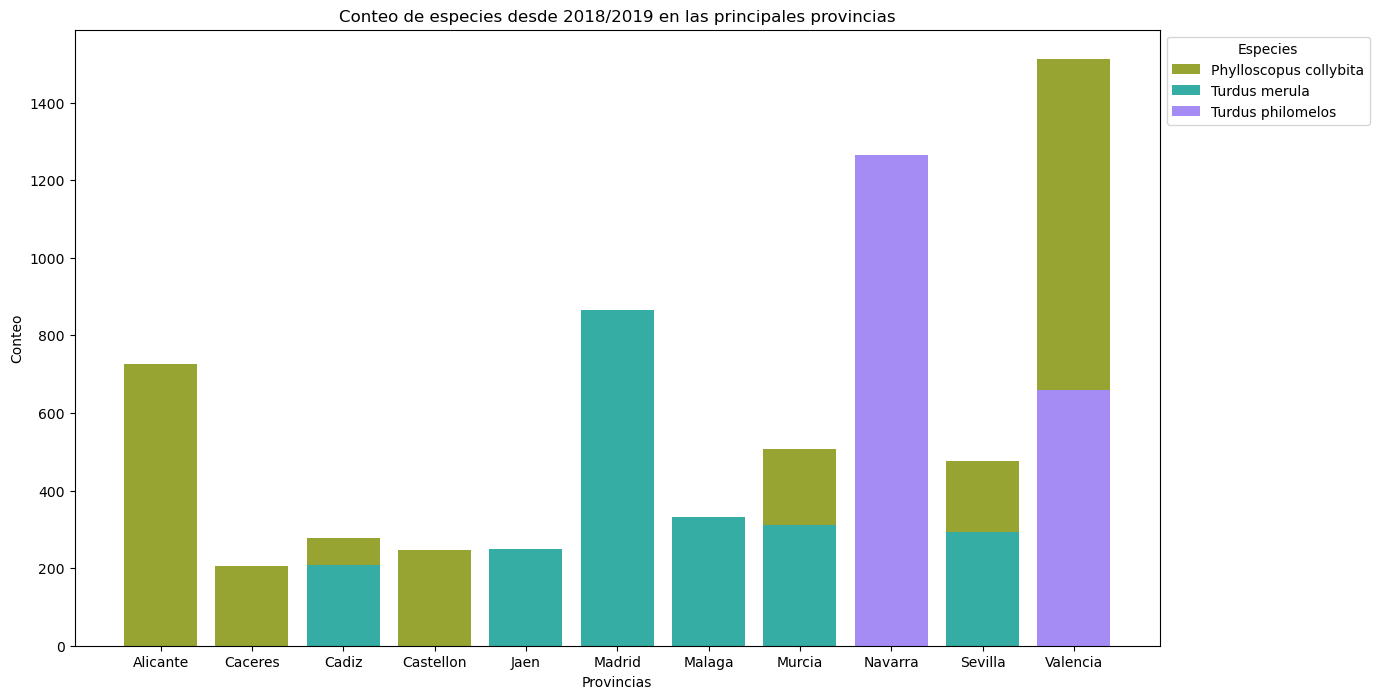

In [144]:
### 2.2. Conteo de especies por provincia en los años 2018 al 2019
plt.figure(figsize=(14, 8))
rango_anos = range(2018, 2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

for species, data in df_filtrado.groupby('species'):
    plt.bar(data['stateProvince'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Provincias')
plt.ylabel('Conteo')
plt.title('Conteo de especies desde 2018/2019 en las principales provincias')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

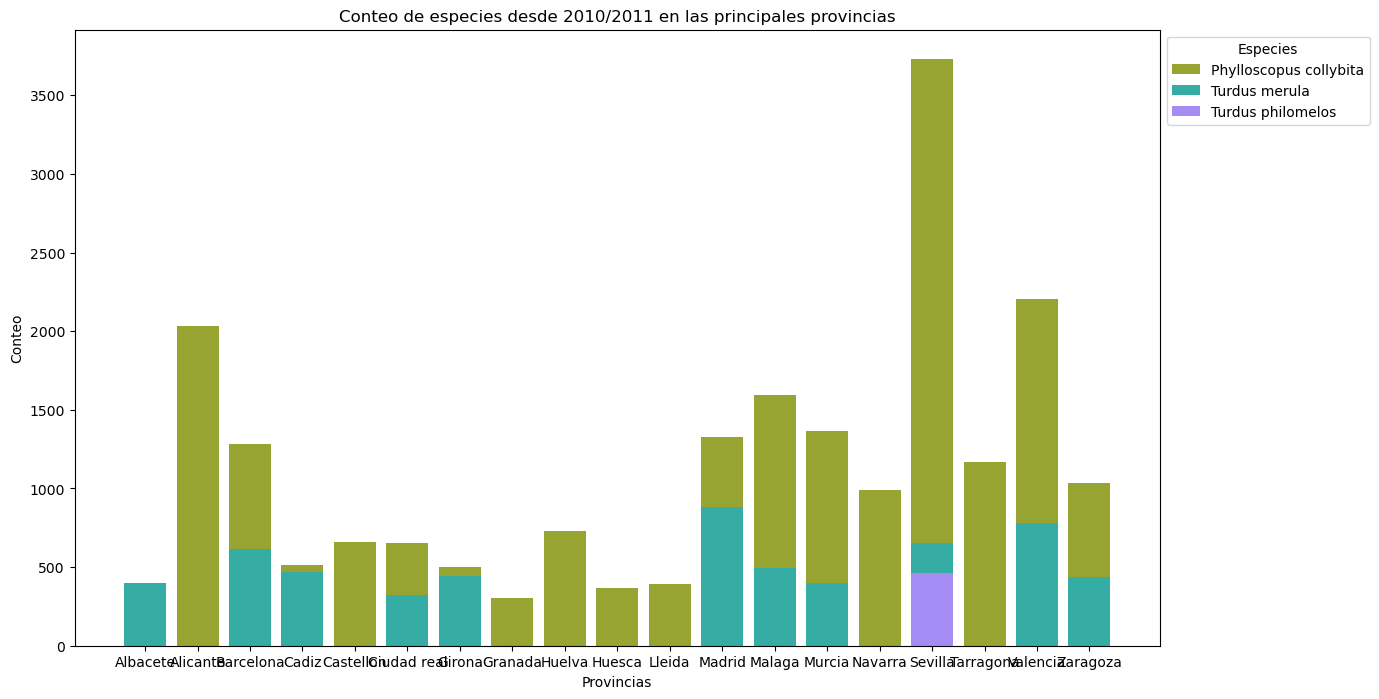

In [147]:
plt.figure(figsize=(14, 8))
rango_anos = range(2010, 2011)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 300)]

for species, data in df_filtrado.groupby('species'):
    plt.bar(data['stateProvince'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Provincias')
plt.ylabel('Conteo')
plt.title('Conteo de especies desde 2010/2011 en las principales provincias')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

### 2.3. Estacionalidad - Conteo de especies por meses

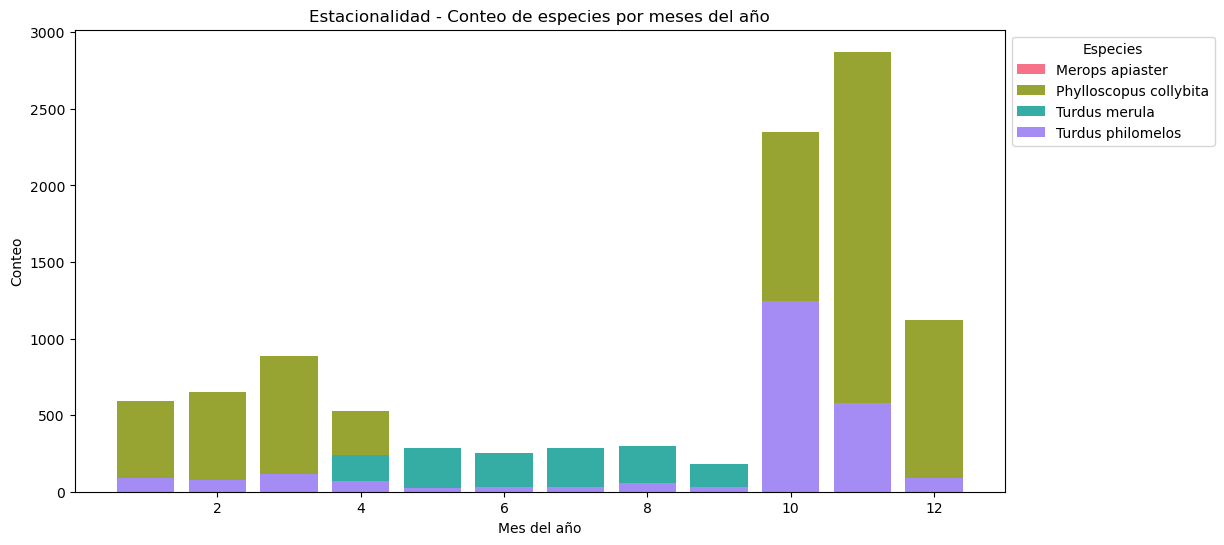

In [153]:
### 2.3. Estacionalidad - Conteo de especies por meses
plt.figure(figsize=(12, 6))
for species, data in grouped_month_df.groupby('species'):
    plt.bar(data['month'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Mes del año')
plt.ylabel('Conteo')
plt.title('Estacionalidad - Conteo de especies por meses del año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()



## 3.Turdus merula : Mirlo

### 3.1. Conteo de Mirlo por año

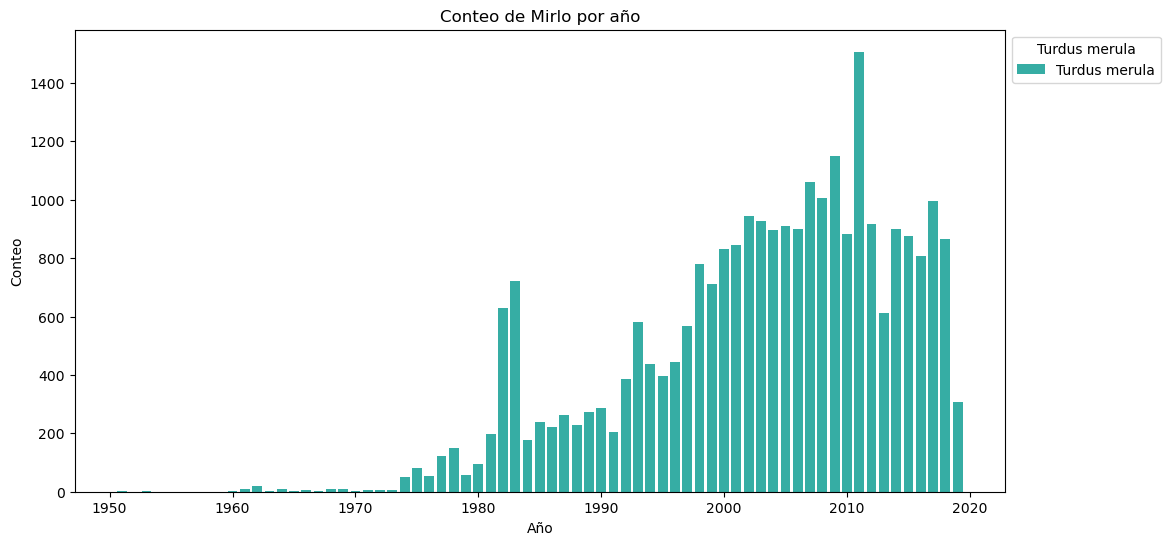

In [131]:
## 3.Turdus merula ("Mirlo")
## Estudio de observaciones sobre Turdus merula ("Mirlo")
especie = 'Turdus merula'
nombre_comun = 'Mirlo'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()


### 3.2.Conteo de Mirlo por provincia

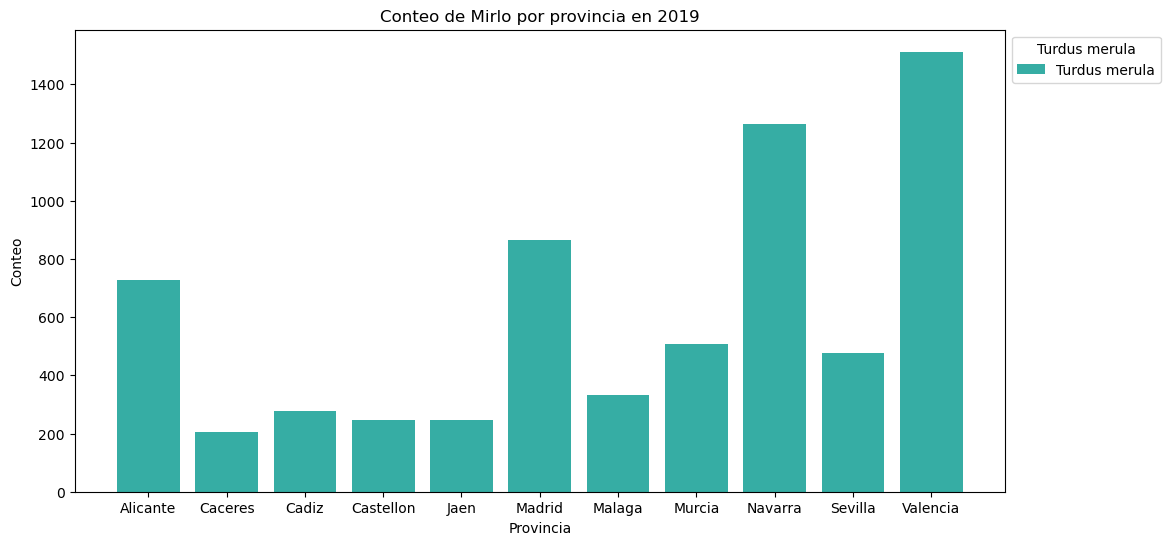

In [132]:
### 3.2. Conteo de Mirlo por provincia
rango_anos = (2018,2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 4.Merops apiaster: Abejaruco

### 4.1. Conteo de Abejaruco por año

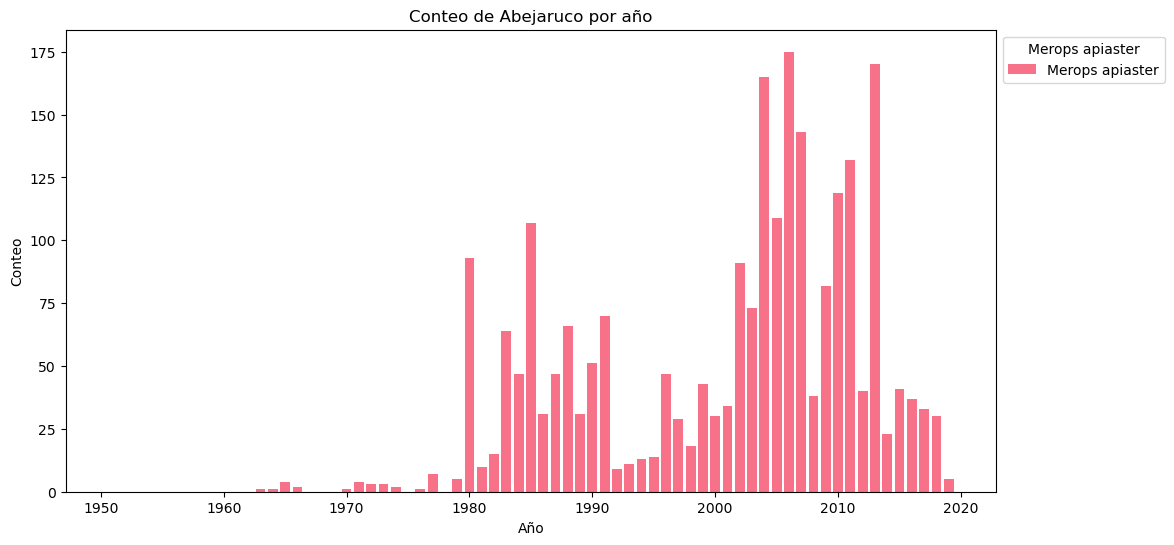

In [133]:
#Estudio de Merops apiaste ("Abejaruco ")
especie = 'Merops apiaster'
nombre_comun = 'Abejaruco'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()


### 4.2. Conteo de Abejaruco por provincia

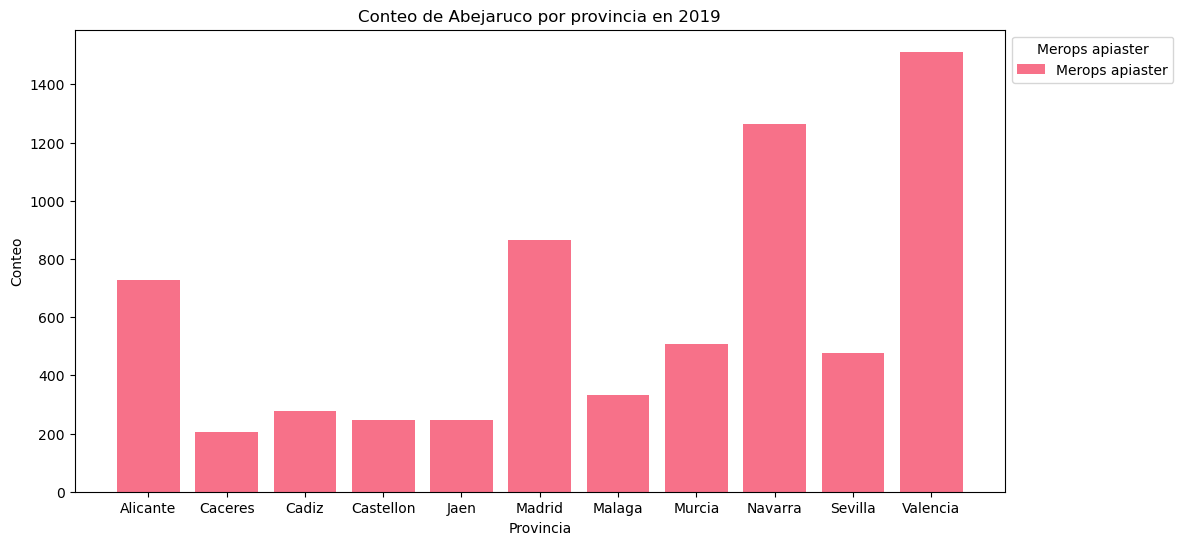

In [134]:
### 3.2. Conteo de Mirlo por provincia
rango_anos = (2018,2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 5.Phylloscopus collybita: Mosquitero común
### 5.1. Conteo de Mosquitero común por año
### 5.2. Conteo de Mosquitero común por provincia

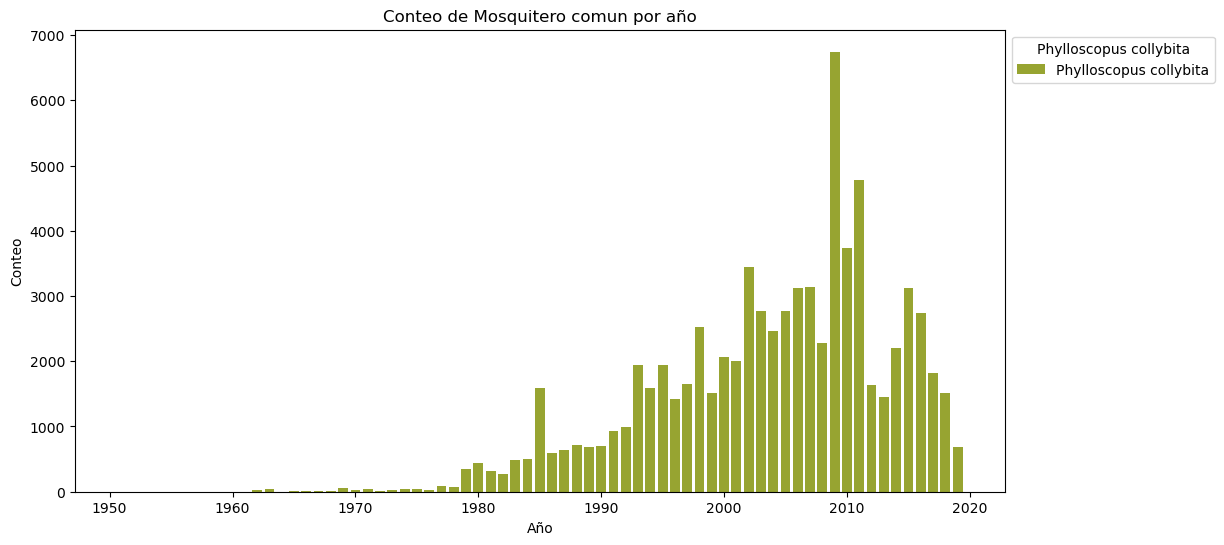

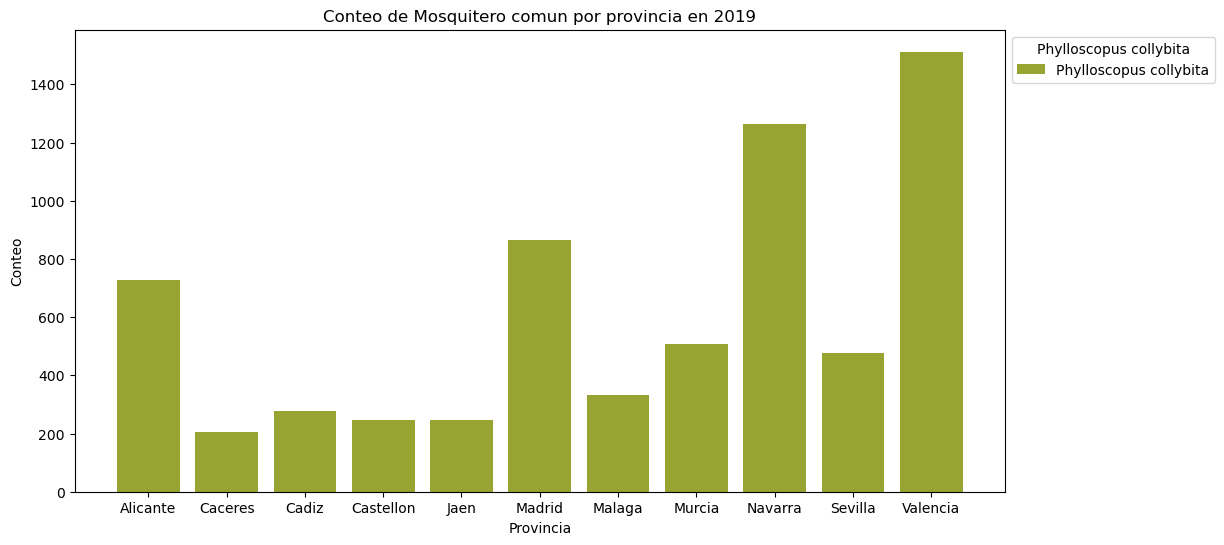

In [135]:
#Estudio de Phylloscopus collybita ("Mosquitero común")
especie = 'Phylloscopus collybita'
nombre_comun = 'Mosquitero comun'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 6.Turdus philomelos: Zorzal común
### 6.1. Conteo de Zorzal común por año
### 6.2. Conteo de Zorzal común por provincia

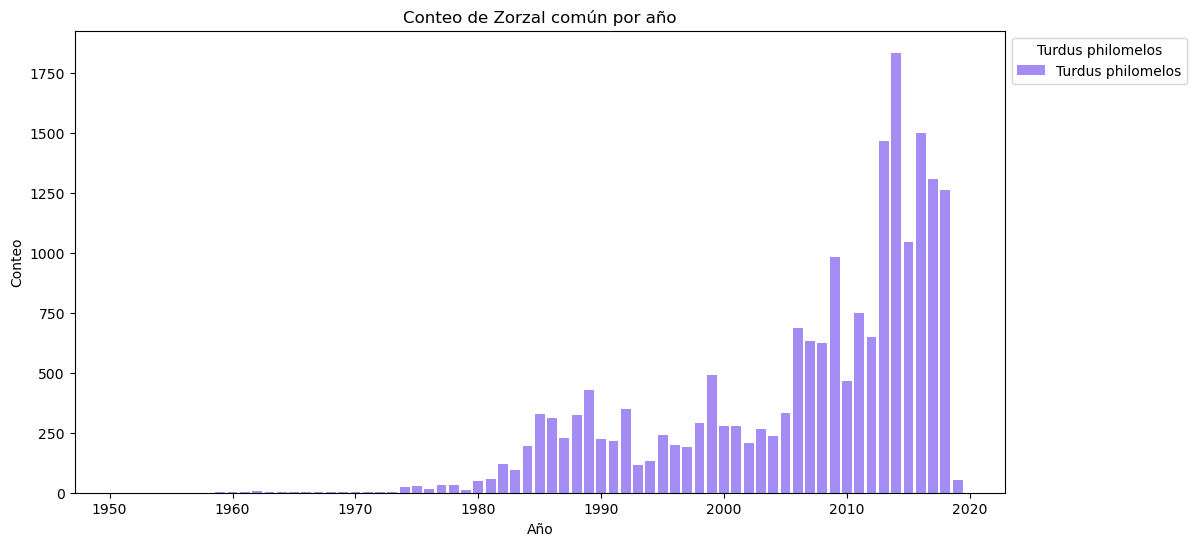

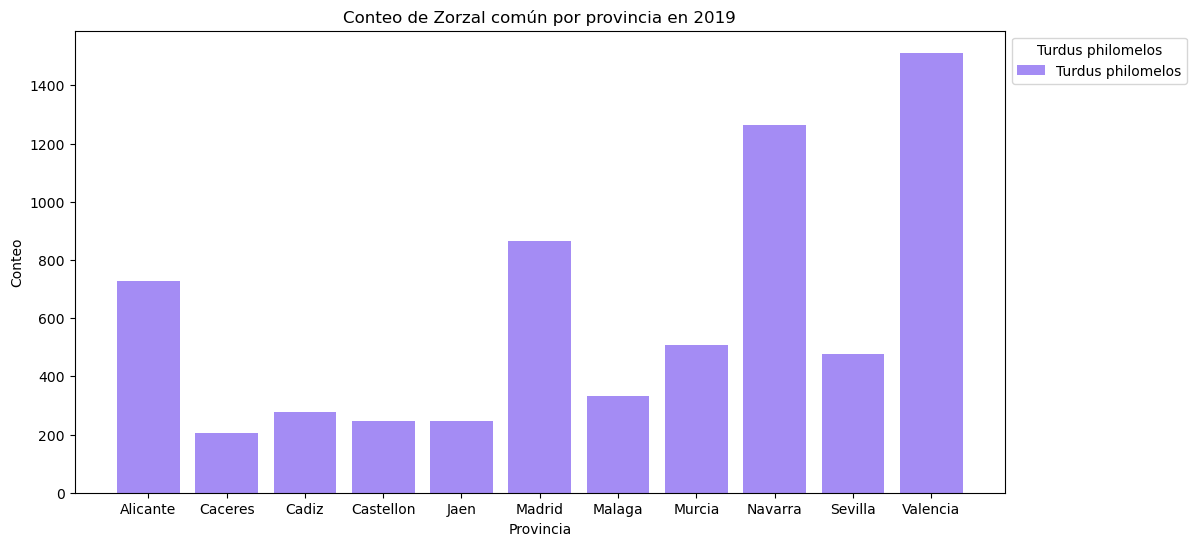

In [136]:

#Estudio de Turdus philomelos ("Zorzal común") 
especie = 'Turdus philomelos'
nombre_comun = 'Zorzal común'

df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

# 7.Predicción series temporales

In [25]:
grouped_year_df

,species,year,stateProvince,count,weekOfYear,month
0,Merops apiaster,1951,Navarra,0.0,50,12
1,Merops apiaster,1953,Guipuzcoa,0.0,29,7
2,Merops apiaster,1959,Guipuzcoa,0.0,19,5
3,Merops apiaster,1960,Asturias,0.0,13,3
4,Merops apiaster,1960,Barcelona,0.0,24,6
...,...,...,...,...,...,...
9383,Turdus philomelos,2019,Teruel,0.0,131,34
9384,Turdus philomelos,2019,Toledo,11.0,627,157
9385,Turdus philomelos,2019,Valencia,54.0,1635,423
9386,Turdus philomelos,2019,Valladolid,1.0,12,3


In [39]:
# Librería estándar
import os
import datetime

# Análisis numérico y datasets
import numpy as np
from scipy import stats

# Análisis y preprocesado de series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Librerías de machine learning
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf  #pip install --upgrade pip   #pip install tensorflow

# Módulos locales, extraidos de la documentación de TensorFlow
from window_generator import WindowGenerator

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
def muestra_informacion_lotes(dataset):
    print('Número de lotes:', len(dataset))
    lotes = [(inputs, targets) for inputs, targets in dataset]
    for i, (inputs, targets) in enumerate(lotes[:10]):
        print('Lote {} => forma entradas: {}, forma salidas: {}'.format(i+1, inputs.shape, targets.shape))
    ultimo_lote = lotes[-1]
    print('Último lote ({}) forma entradas: {}, forma salidas: {}'.format(len(dataset), ultimo_lote[0].shape, ultimo_lote[0].shape))


In [74]:
especie = 'Turdus philomelos'
datos = grouped_year_df[grouped_year_df['species'] == especie]
datos = datos.drop('species', axis=1)
datos = datos.drop('stateProvince', axis=1)

datos

,year,count,weekOfYear,month
7041,1951,0.0,50,12
7042,1953,0.0,29,7
7043,1959,1.0,19,5
7044,1960,0.0,13,3
7045,1960,0.0,24,6
...,...,...,...,...
9383,2019,0.0,131,34
9384,2019,11.0,627,157
9385,2019,54.0,1635,423
9386,2019,1.0,12,3


In [75]:
# Proporciones: 70%-20%-10%
tamaño = len(datos)
train = datos[0:int(tamaño*0.7)]
val = datos[int(tamaño*0.7):int(tamaño*0.9)]
test = datos[int(tamaño*0.9):]

In [78]:
#generacion ventana simple
wg_7_1 = WindowGenerator(train_df=train,
                         val_df=val,
                         test_df=test,
                         input_width=7,
                         label_width=1,
                         shift=1,
                         label_columns=['count'])

In [79]:
wg_7_1
muestra_informacion_lotes(wg_7_1.train)

Número de lotes: 52
Lote 1 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 2 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 3 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 4 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 5 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 6 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 7 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 8 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 9 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 10 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Último lote (52) forma entradas: (3, 7, 4), forma salidas: (3, 7, 4)


In [80]:
def compile_and_fit(model, window, patience=2, max_epochs=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [81]:
RESULTADOS = pd.DataFrame(columns=['train', 'validation', 'test'])
RESULTADOS

,train,validation,test



Epoch 1/50

52/52 [==============================] - 1s 9ms/step - loss: 2413648.2500 - mean_absolute_error: 926.7820 - val_loss: 4942915.5000 - val_mean_absolute_error: 1555.0947
Epoch 2/50
52/52 [==============================] - 0s 3ms/step - loss: 1927788.8750 - mean_absolute_error: 832.5857 - val_loss: 3992988.0000 - val_mean_absolute_error: 1389.7992
Epoch 3/50
52/52 [==============================] - 0s 2ms/step - loss: 1537509.2500 - mean_absolute_error: 759.4465 - val_loss: 3203515.0000 - val_mean_absolute_error: 1245.9954
Epoch 4/50
52/52 [==============================] - 0s 3ms/step - loss: 1235806.2500 - mean_absolute_error: 702.8514 - val_loss: 2576371.5000 - val_mean_absolute_error: 1126.6868
Epoch 5/50
52/52 [==============================] - 0s 3ms/step - loss: 1006558.2500 - mean_absolute_error: 658.7297 - val_loss: 2092876.8750 - val_mean_absolute_error: 1027.4943
Epoch 6/50
52/52 [==============================] - 0s 3ms/step - loss: 831162.5000 - mean_absolute_err

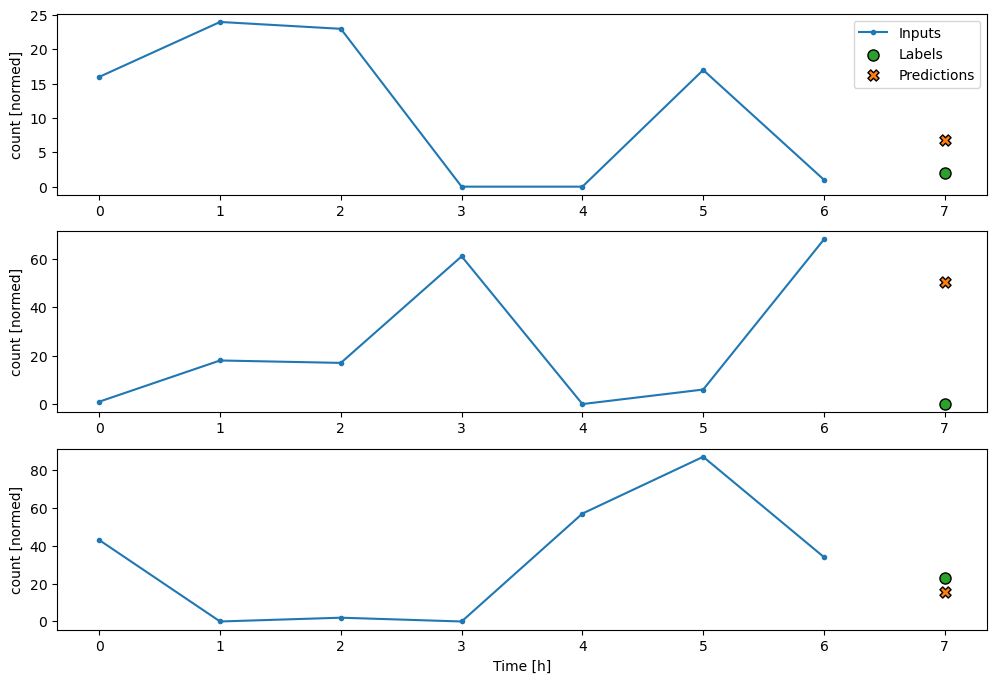

In [82]:
# Construir un modelo llamado 'lineal' con una única capa densa de una sola unidad. Usar los siguientes 
# elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
lineal = tf.keras.Sequential([
    tf.keras.layers.Dense(1)  # Capa densa con una sola unidad
])

# Compilar y evaluar el modelo 'lineal' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lineal, wg_7_1)

resultado_train = lineal.evaluate(wg_7_1.train)[-1]
resultado_val = lineal.evaluate(wg_7_1.val)[-1]
resultado_test = lineal.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['Lineal'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=lineal)

In [84]:
RESULTADOS

,train,validation,test
Lineal,26.052301,72.689232,64.916824


In [83]:

history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

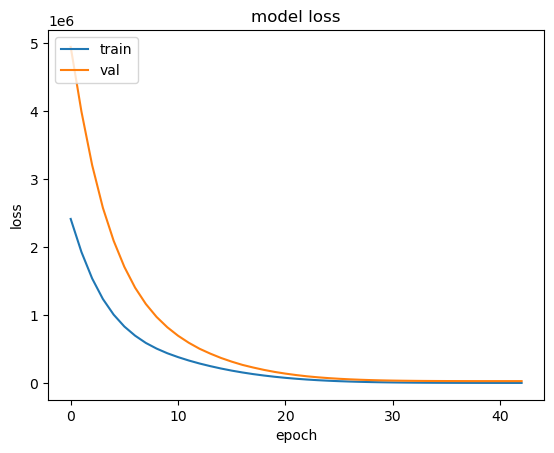

In [85]:
# curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

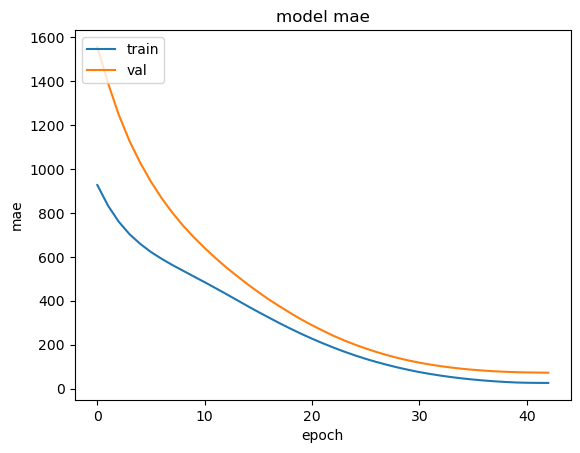

In [86]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/50
52/52 [==============================] - 1s 6ms/step - loss: 24988.6914 - mean_absolute_error: 137.6687 - val_loss: 29181.5762 - val_mean_absolute_error: 96.9778
Epoch 2/50
52/52 [==============================] - 0s 3ms/step - loss: 9573.6816 - mean_absolute_error: 83.5971 - val_loss: 27707.2363 - val_mean_absolute_error: 81.0925
Epoch 3/50
52/52 [==============================] - 0s 2ms/step - loss: 5374.0825 - mean_absolute_error: 60.2674 - val_loss: 27882.5469 - val_mean_absolute_error: 75.4168
Epoch 4/50
8/8 [==============================] - 0s 1ms/step - loss: 43255.7734 - mean_absolute_error: 76.7983


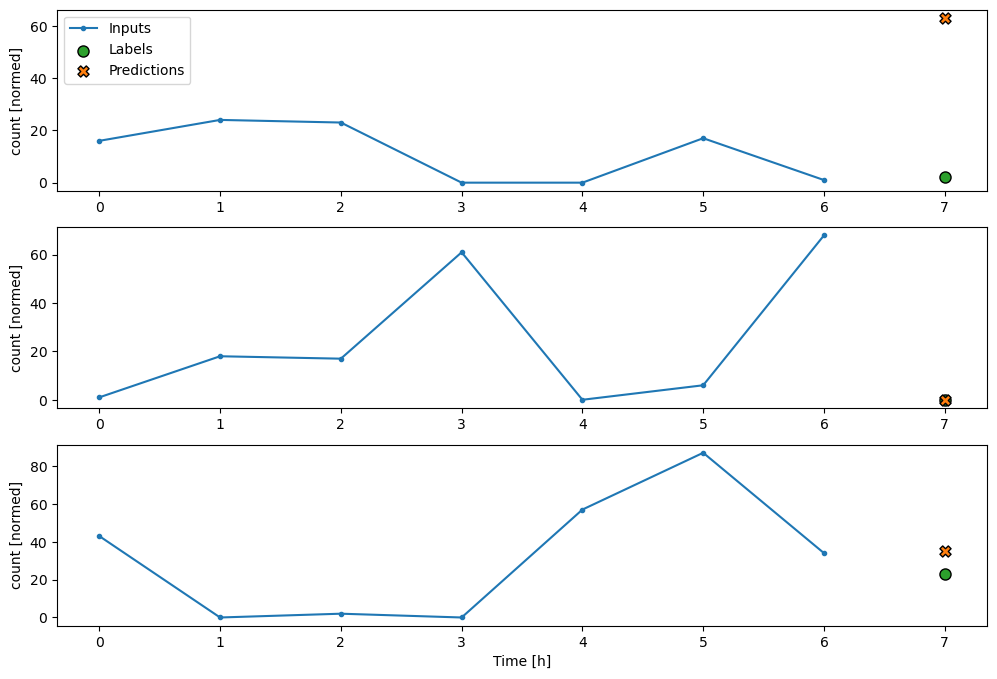

In [88]:
# construir un modelo llamado 'denso' con:
#   - Dos capas densas de 4 unidades, con función de activación ReLU
#   - Una capa densa final de una sola unidad, con función de activación lineal
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense

denso = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# compilar y evaluar el modelo 'denso' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Denso', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(denso, wg_7_1)

resultado_train = denso.evaluate(wg_7_1.train)[-1]
resultado_val = denso.evaluate(wg_7_1.val)[-1]
resultado_test = denso.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['Denso'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=denso)

In [89]:
RESULTADOS

,train,validation,test
Lineal,26.052301,72.689232,64.916824
Denso,45.370907,72.876503,76.798264


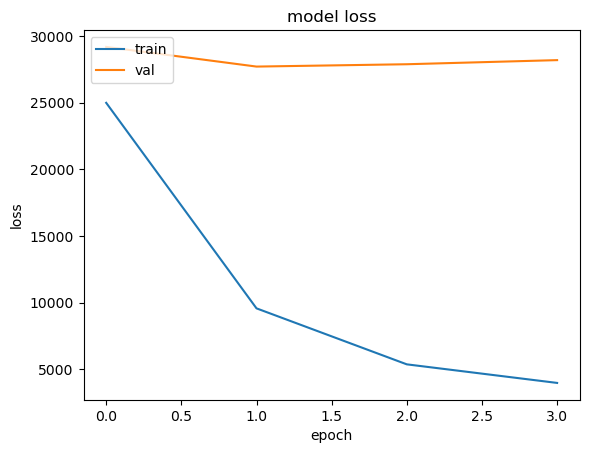

In [90]:
# Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/300
52/52 [==============================] - 5s 21ms/step - loss: 2724.5935 - mean_absolute_error: 21.7347 - val_loss: 30976.7461 - val_mean_absolute_error: 71.3809
Epoch 2/300
52/52 [==============================] - 0s 6ms/step - loss: 2708.9871 - mean_absolute_error: 21.5514 - val_loss: 30918.2363 - val_mean_absolute_error: 71.0888
Epoch 3/300
52/52 [==============================] - 0s 7ms/step - loss: 2690.5203 - mean_absolute_error: 21.3616 - val_loss: 30850.4043 - val_mean_absolute_error: 70.7650
Epoch 4/300
52/52 [==============================] - 0s 6ms/step - loss: 2668.2051 - mean_absolute_error: 21.1774 - val_loss: 30771.6895 - val_mean_absolute_error: 70.4391
Epoch 5/300
52/52 [==============================] - 0s 6ms/step - loss: 2642.6057 - mean_absolute_error: 21.0398 - val_loss: 30681.4941 - val_mean_absolute_error: 70.1107
Epoch 6/300
52/52 [==============================] - 0s 7ms/step - loss: 2617.3591 - mean_absolute_error: 20.9569 - val_loss: 30601.1777 - 

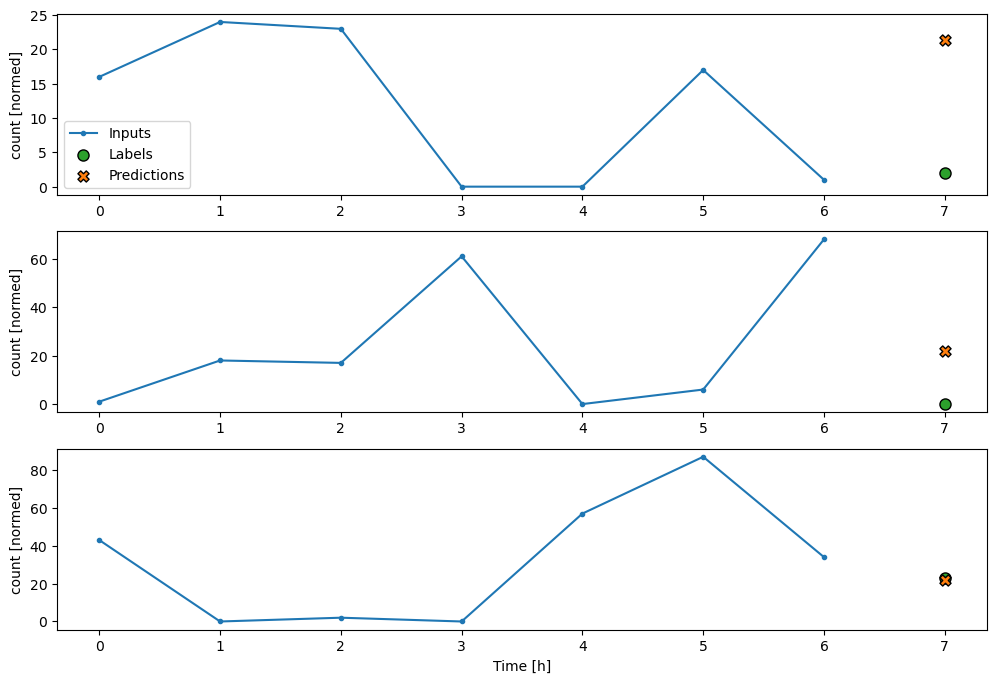

In [91]:
# Construir y evaluar un modelo llamado 'lstm' con:
#   - Dos capas LSTM con 4 unidades
#   - Una capa densa de una sola unidad
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
#   - tf.keras.layers.LSTM

lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(1)
])

# EJERCICIO: compilar y evaluar el modelo 'lstm' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'LSTM', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lstm, wg_7_1, max_epochs=300)

resultado_train = lstm.evaluate(wg_7_1.train)[-1]
resultado_val = lstm.evaluate(wg_7_1.val)[-1]
resultado_test = lstm.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['LSTM'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=lstm)

In [92]:
RESULTADOS

,train,validation,test
Lineal,26.052301,72.689232,64.916824
Denso,45.370907,72.876503,76.798264
LSTM,26.381138,67.131332,60.496895


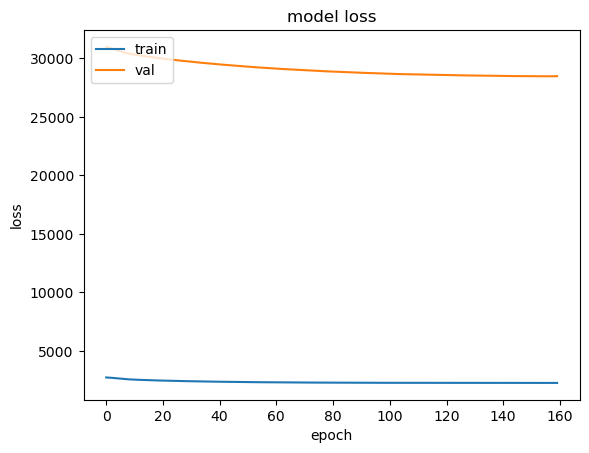

In [93]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/300
52/52 [==============================] - 5s 23ms/step - loss: 2734.2639 - mean_absolute_error: 21.8819 - val_loss: 31028.8203 - val_mean_absolute_error: 71.6436
Epoch 2/300
52/52 [==============================] - 0s 7ms/step - loss: 2724.6729 - mean_absolute_error: 21.7352 - val_loss: 30995.1367 - val_mean_absolute_error: 71.4702
Epoch 3/300
52/52 [==============================] - 0s 6ms/step - loss: 2709.4456 - mean_absolute_error: 21.5630 - val_loss: 30936.8535 - val_mean_absolute_error: 71.1701
Epoch 4/300
52/52 [==============================] - 0s 7ms/step - loss: 2686.9736 - mean_absolute_error: 21.3563 - val_loss: 30851.6309 - val_mean_absolute_error: 70.7715
Epoch 5/300
52/52 [==============================] - 0s 7ms/step - loss: 2660.7073 - mean_absolute_error: 21.1975 - val_loss: 30765.8223 - val_mean_absolute_error: 70.4194
Epoch 6/300
52/52 [==============================] - 0s 6ms/step - loss: 2637.0183 - mean_absolute_error: 21.1087 - val_loss: 30677.0371 - 

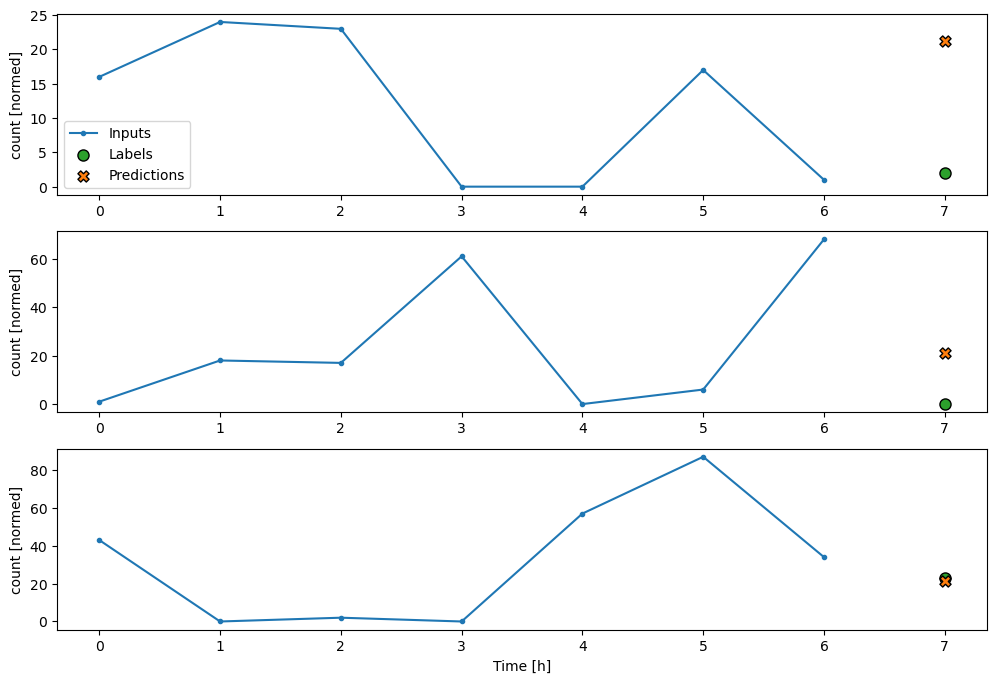

In [94]:
# construir y evaluar un modelo llamado 'lstm_dropout' con:
#   - Dos capas LSTM con 4 unidades
#   - Una capa dropout con una reducción del 20%
#   - Una capa densa de una sola unidad
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
#   - tf.keras.layers.LSTM

lstm_dropout = tf.keras.Sequential([
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# EJERCICIO: compilar y evaluar el modelo 'lstm_dropout' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lstm_dropout, wg_7_1, max_epochs=300)

resultado_train = lstm_dropout.evaluate(wg_7_1.train)[-1]
resultado_val = lstm_dropout.evaluate(wg_7_1.val)[-1]
resultado_test = lstm_dropout.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['LSTM-dropout'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=lstm_dropout)

In [95]:
RESULTADOS

,train,validation,test
Lineal,26.052301,72.689232,64.916824
Denso,45.370907,72.876503,76.798264
LSTM,26.381138,67.131332,60.496895
LSTM-dropout,26.257959,67.099457,60.369560


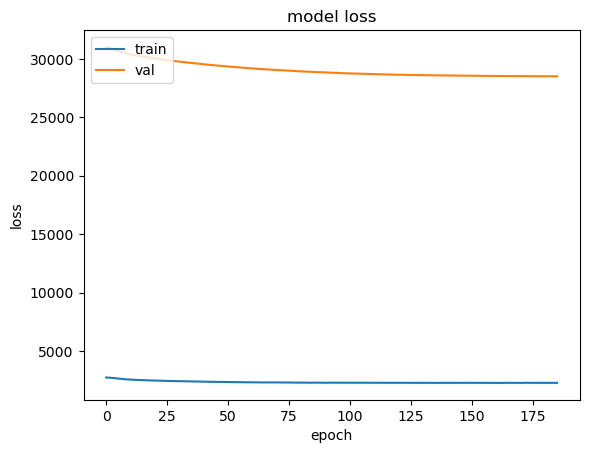

In [96]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()